In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
#import file_io

%matplotlib inline

In [2]:
# Random seed - current time
seed_time = int((time.time()))
np.random.seed(seed_time)
print "Random Seed", seed_time

with np.load("notMNIST.npz") as data:
    images, labels = data["images"], data["labels"]
images.shape

# Used for TF Boolean comparisons
TF_TRUE = tf.constant(1, tf.int32)
TF_FALSE = tf.constant(0, tf.int32)

# Parameters

# Constant parameters
n_input = 784 # Input data dimension
n_classes = 10 # Output classes
training_set_size = 15000 
display_step = 1
n_units = [n_input] # include at least the input 

# Less constant parameters
batch_size = 1000
num_epochs = 200
momentum = 0.99

random_hyperparameters = True

# NN Parameters
isDropout = True
dropout_rate = 0.0
    
learning_rate = 0.1
n_layers = 1
n_hidden1 = 1000 # Number of hidden units in layer 1
n_hidden2 = 500 # Number of hidden units in layer 2

# Manual hyperparameters
if random_hyperparameters == False:
    n_units += [n_hidden1]
    if n_layers == 2:
        n_units += [n_hidden2]
    n_units += [n_classes] # include output layer

# Random hyperparameter sampling - note: random_integers(low,high) gives low <= x <= high
elif random_hyperparameters == True:
    #n_units = [n_input]
    n_layers = np.random.random_integers(1,3) # Random number of layers, between 1 and 3
    for i in range(0, n_layers):
        n_units += [np.random.random_integers(100,500)] # Random number of hidden units per layer
    n_units += [n_classes]
    #isDropout = bool(np.random.random_integers(0,2))
    log_learning_rate = (-2 + 4) * np.random.random_sample() - 2
    learning_rate = np.float32(np.exp(log_learning_rate))
    
# After deciding whether to use dropout
if isDropout == True:
    dropout_rate = 0.5
else: 
    dropout_rate = 0.0

def rearrangeImages(image_array):
    rearranged = np.zeros((image_array.shape[2], image_array.shape[0] * image_array.shape[1]), dtype=np.float32)
    for num in range(0, image_array.shape[2]):
        flat_image = image_array[:,:,num].flatten()
        max_elem = np.amax(flat_image)
        for i in range(0, len(flat_image)):
            flat_image[i] = flat_image[i] / max_elem
        rearranged[num,:] = flat_image
    return rearranged
                
    
def oneHot(labels, vector_size):
    oneHot = np.zeros((len(labels), vector_size))
    for i in range(0, len(labels)):
        label_index = labels[i]
        oneHot[i, label_index] = 1
    return oneHot

def preprocess_data(images, labels):
    # Create one-hot label vectors and flatten images
    one_hot_labels = oneHot(labels, 10)
    flat_images = rearrangeImages(images)
    return flat_images, one_hot_labels

def neural_network(_X, _weights, _biases, keep_prob): # 1 <= n_layers
    # Hidden units using a ReLU activation function
    hidden_layers = {} 
    n_layers = len(_weights) - 1
    
    # Always include at least one layer
    hidden_layers[1] = tf.nn.relu(tf.add(tf.matmul(_X, _weights[1]), _biases[1]))
    
    if (n_layers > 1):
        for i in range(2, n_layers + 1):
            hidden_layers[i] = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(hidden_layers[i-1], _weights[i]), _biases[i])), keep_prob)
            
    return tf.nn.dropout(tf.matmul(hidden_layers[n_layers], _weights[n_layers + 1]) + _biases[n_layers + 1], keep_prob)

Random Seed 1455716111


In [3]:
# Separate training, validation and test sets
flat_images, one_hot_labels = preprocess_data(images, labels)
training_labels = one_hot_labels[0:15000]
validation_labels = one_hot_labels[15000:16000]
testing_labels = one_hot_labels[16000:]

training_images = flat_images[:15000,:]
validation_images = flat_images[15000:16000,:]
testing_images = flat_images[16000:,:]


In [4]:
############# TF GRAPHS
### Logistic Regression

#Placeholders
X = tf.placeholder("float32", shape=(None, n_input)) # 28x28 flattened arrays
Y = tf.placeholder("float32", shape=(None, n_classes)) # 10-class classifier

#Variables
W = tf.Variable(np.random.randn(n_input, n_classes).astype("float32"), name="weight")
b = tf.Variable(np.random.randn(n_classes).astype("float32"), name="bias")

logits_lr = tf.add(tf.matmul(X, W), b)
output = tf.nn.softmax(logits_lr)
cost_lr = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_lr, targets=Y))
correct_prediction_lr = tf.equal(tf.argmax(Y,1), tf.argmax(output,1))#tf.argmax(Y_,1))
accuracy_lr = tf.reduce_mean(tf.cast(correct_prediction_lr, tf.float32))

### Neural Network

# Store layers' weights & biases
weights = {}
biases = {}
for l in range(1, n_layers + 2):
    # Normalize by the number of input units
    weights[l] = tf.Variable(tf.random_normal([n_units[l-1], n_units[l]], stddev = np.sqrt(1.0/n_units[l-1]) ))
    biases[l] = tf.Variable(tf.random_normal([n_units[l]], stddev = np.sqrt(1.0/n_units[l-1]) ))

# TF Graph Input
input_images = tf.placeholder(tf.float32, shape=(None, n_input))
label = tf.placeholder(tf.float32, shape=[None, n_classes])
pred = tf.placeholder(tf.float32, shape=[None, n_classes])

keep_prob = tf.placeholder(tf.float32)

# Construct model
logits = neural_network(input_images, weights, biases, keep_prob) 

# Define cost
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, targets=label))

# Make prediction
prediction = tf.nn.softmax(logits)

# Compare prediction with labels to evaluate accuracy
correct_preds = tf.equal(tf.argmax(prediction, 1), tf.argmax(label, 1))
accuracy_rate = tf.reduce_mean(tf.cast(correct_preds, "float"))

In [5]:
def nn_classification(learning_rate, batch_size, num_epochs):
    train_errors = []
    valid_errors = []
    train_cost = []
    valid_cost = []
    testing_accuracy = []

    train_op = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)# momentum=momentum)

    # Initializing the variables
    init = tf.initialize_all_variables()

    # Launch the graph
    with tf.Session() as sess:
        sess.run(init)

        # Training cycle
        for epoch in range(num_epochs):
            num_batches = int(training_set_size/batch_size)
            # Loop over all batches
            for i in range(num_batches):
                batch_xs = training_images[i * batch_size: (i + 1) * batch_size]
                batch_ys = training_labels[i * batch_size: (i + 1) * batch_size]
                feed_dict = {input_images : batch_xs, label : batch_ys, keep_prob : 1.0 - dropout_rate}
                l, _ = sess.run([cost, train_op], feed_dict=feed_dict)
                
            tc, ta = sess.run([cost, accuracy_rate], feed_dict={input_images: training_images, label: training_labels, keep_prob : 1.0})
            train_errors.append((1-ta)*batch_size) 
            train_cost.append(-tc) 
            vc, va  = sess.run([cost, accuracy_rate], feed_dict={input_images: validation_images, label: validation_labels, keep_prob : 1.0})
            valid_errors.append((1-va)*len(validation_labels)) 
            valid_cost.append(-vc)
            testing_accuracy.append( sess.run(accuracy_rate,feed_dict={input_images: testing_images, label: testing_labels, keep_prob : 1.0}) )

            # Display per epoch 
            if (epoch % 15) == 0:
                print "Epoch:", '%04d' % (epoch+1)
                print("Minibatch accuracy: %.5f, cost: %.5f " % ((1-train_errors[epoch]/len(validation_labels)), tc))
                print("Validation Accuracy: %.5f, cost: %.5f" % ((1-valid_errors[epoch]/batch_size), vc))
    return train_errors, valid_errors, train_cost, valid_cost, testing_accuracy

In [6]:
def lr_classification(learning_rate, batch_size, num_epochs):
    accuracy_testing = []
    training_errors = []
    validation_errors = []
    training_costs = []
    validation_costs = []
    
    train_op_lr = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost_lr)
    # Initializing the variables
    init = tf.initialize_all_variables()

    # Launch the graph
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            for i in xrange(int(training_set_size/batch_size)):
                x_batch = training_images[i * batch_size: (i + 1) * batch_size]
                y_batch = training_labels[i * batch_size: (i + 1) * batch_size]
                cost_np, _ = sess.run([cost_lr, train_op_lr], feed_dict={X: x_batch, Y: y_batch})

            cost_train, accuracy_train = sess.run([cost_lr, accuracy_lr],feed_dict={X: training_images, Y: training_labels})
            cost_eval, accuracy_eval = sess.run([cost_lr, accuracy_lr], feed_dict={X: validation_images, Y: validation_labels})    
            accuracy_test = sess.run(accuracy_lr, feed_dict={X: testing_images, Y: testing_labels})  

            training_costs.append(-cost_train)
            validation_costs.append(-cost_eval)
            accuracy_testing.append(accuracy_test)
            training_errors.append(len(training_labels) * (1-accuracy_train))
            validation_errors.append(len(validation_labels) * (1-accuracy_eval))
            
    return training_errors, validation_errors, training_costs, validation_costs, accuracy_testing

In [7]:
#ta, va, tc, vc, test = nn_classification(learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs)
ta, va, tc, vc, test = lr_classification(learning_rate=learning_rate, batch_size=batch_size, num_epochs=num_epochs)

1
2
3
4
5
6
7
8
9
11
12
13
14
15
16
17
18
19
21
22
23
24
25
26
27
28
29
31
32
33
34
35
36
37
38
39
41
42
43
44
45
46
47
48
49
51
52
53
54
55
56
57
58
59
61
62
63
64
65
66
67
68
69
71
72
73
74
75
76
77
78
79
81
82
83
84
85
86
87
88
89
91
92
93
94
95
96
97
98
99
101
102
103
104
105
106
107
108
109
111
112
113
114
115
116
117
118
119
121
122
123
124
125
126
127
128
129
131
132
133
134
135
136
137
138
139
141
142
143
144
145
146
147
148
149
151
152
153
154
155
156
157
158
159
161
162
163
164
165
166
167
168
169
171
172
173
174
175
176
177
178
179
181
182
183
184
185
186
187
188
189
191
192
193
194
195
196
197
198
199


Best validation epoch: 200 with validation accuracy: 0.768999993801
Test accuracy for the best validation case: 0.765809
Number of test errors: 637.000007629
0.855616 True [784, 323, 273, 101, 10]


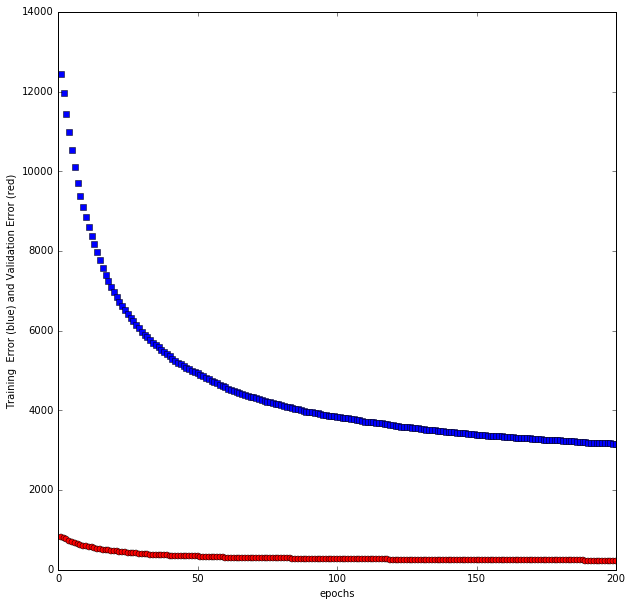

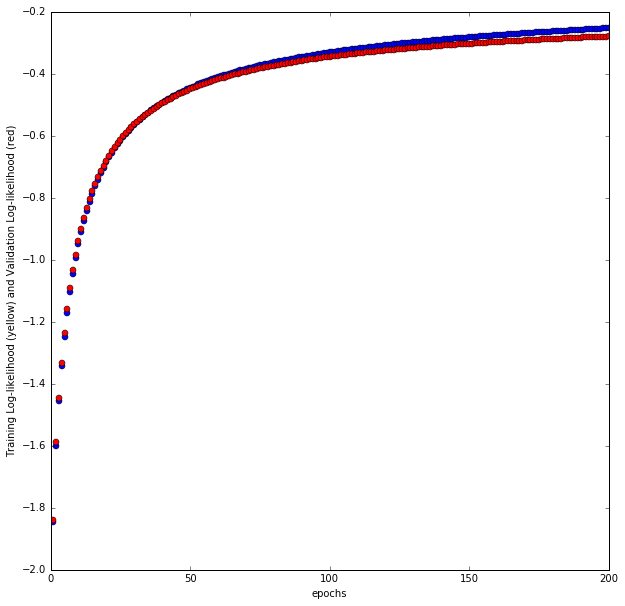

In [8]:
# Create a plot with respect to epoch size and validation error and training error

print "Best validation epoch:", np.argmax(vc) + 1, "with validation accuracy:", (1000.0 - va[np.argmax(vc)])/1000.0
print "Test accuracy for the best validation case:", test[np.argmax(vc)]
print "Number of test errors:", (1.0 -test[np.argmax(vc)]) * len(testing_labels)
print learning_rate, isDropout, n_units

plt.figure(1,figsize=(10,10))
plt.xlabel("epochs"); plt.ylabel("Training  Error (blue) and Validation Error (red)")
plt.plot(range(1,num_epochs+1), ta,'bs')
plt.plot(range(1,num_epochs+1), va, 'ro')
# Create a plot with respect to epoch size and validation L and training L
plt.figure(2,figsize=(10,10))
plt.xlabel("epochs"); plt.ylabel("Training Log-likelihood (yellow) and Validation Log-likelihood (red)")
plt.plot(range(1,num_epochs+1), tc,'bo')
plt.plot(range(1,num_epochs+1), vc, 'ro')
